# Линейные модели в классификации текстов
Основано на материалах подготовленных Ильей Ирхиным

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import heapq

import numpy as np

from IPython.display import Image
from sklearn.datasets import fetch_20newsgroups

## Посмотрим на данные

In [3]:
dataset = fetch_20newsgroups()

### Пример элемента выборки

In [4]:
print('Features\n\n', dataset['data'][0])
print('Target\n\n', dataset.target[0])

Features

 From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Target

 7


### Категории

In [5]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Train и test выборки

Возьмём 2 темы из одного раздела, возможно, их будет сложно отличить друг от друга

In [6]:
categories = [
    'rec.sport.baseball',
    'rec.sport.hockey'
]
train_data = fetch_20newsgroups(subset='train',
                                categories=categories,
                                remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test',
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'))

In [7]:
print('# examples in train', len(train_data.data))
print('# examples in test', len(test_data.data))

# examples in train 1197
# examples in test 796


## Приведем данные к виду, с которым можно работать

### Векторизация

Для векторизации текстов воспользуемся CountVectorizer, он представляет документ как мешок слов. Можно всячески варировать извлечение признаков (убирать редкие слова, убирать частые слова, убирать слова общей лексики, брать биграмы и т.д.)

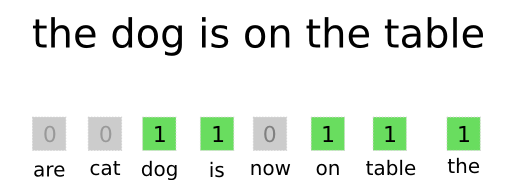

In [8]:
Image('pics/bag_of_words.png', width=600)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
count_vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 2)) 

Мы будем работать с эффективным представлением матриц "Compressed Sparse Row Format" (CSR). Почитать о формате можно здесь: https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)

In [12]:
dense_feature_matrix = count_vectorizer.fit_transform(train_data.data)
sparse_feature_matrix = dense_feature_matrix.toarray()

In [13]:
print('Dense matrix shape', dense_feature_matrix.data.shape)
print('Sparse matrix shape', sparse_feature_matrix.shape)

Dense matrix shape (142691,)
Sparse matrix shape (1197, 13338)


In [14]:
%%time
dense_feature_matrix.sum()

CPU times: user 1.06 ms, sys: 253 µs, total: 1.31 ms
Wall time: 1.1 ms


228812

In [15]:
%%time
sparse_feature_matrix.sum()

CPU times: user 32.8 ms, sys: 21.7 ms, total: 54.5 ms
Wall time: 60.4 ms


228812

### Словарь токен-слово

Соберем обратный словарь, в котором каждому токену (номеру) будет сопоставлено слово из оригинального словаря

In [16]:
num_2_words = {
    v: k
    for k, v in count_vectorizer.vocabulary_.items()
}

## Начнем обучать линейные модели

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

### Обучим логистическую регрессию предсказывать тему документа

In [18]:
algo = LogisticRegression()
algo.fit(dense_feature_matrix, train_data.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Слова с наименьшим отрицательным весом являются характерными словами класса 0

Слова с наибольшим положительным весом являются характерными словами класса 1

In [19]:
W = algo.coef_.shape[1]
NUM_WORDS = 10
class_2_function = {'Baseball': heapq.nsmallest, 'Hockey': heapq.nlargest}

for category, function in class_2_function.items():
    topic_words = [
        num_2_words[w_num]
        for w_num in function(NUM_WORDS, range(W), key=lambda w: algo.coef_[0, w])
    ]
    print(category)
    print(', '.join(topic_words))

Baseball
runs, jewish, baseball, braves, stadium, cubs, day, hall, pitching, giants
Hockey
hockey, nhl, playoff, mask, wings, detroit, leafs, the nhl, playoffs, roger


### Оценим качество

Сравним качество на фолдах с качеством на трейне и на отложенном тесте

In [20]:
algo = LogisticRegression()
arr = cross_val_score(algo, dense_feature_matrix, train_data.target, cv=5, scoring='accuracy')
print(arr)
print(np.mean(arr))

[0.875      0.89583333 0.88702929 0.83682008 0.85774059]
0.8704846582984658


Почему это неправильная кроссвалидация?

In [21]:
algo.fit(dense_feature_matrix, train_data.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
print('Train accuracy', accuracy_score(algo.predict(dense_feature_matrix), train_data.target))
print('Test accuracy', accuracy_score(algo.predict(count_vectorizer.transform(test_data.data)), test_data.target))

Train accuracy 0.9849624060150376
Test accuracy 0.8605527638190955


Мы видим переобучение, почему?

### Регуляризация

Добавим l1 - регуляризатор с коэффициентом 0.1

In [23]:
algo = LogisticRegression(penalty='l1', C=0.1)
arr = cross_val_score(algo, dense_feature_matrix, train_data.target, cv=5, scoring='accuracy')
print(arr)
print(np.mean(arr))

[0.79166667 0.75       0.79079498 0.80334728 0.79497908]
0.78615760111576


In [24]:
algo.fit(sparse_feature_matrix, train_data.target)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
print('Train accuracy', accuracy_score(algo.predict(dense_feature_matrix), train_data.target))
print('Test accuracy', accuracy_score(algo.predict(count_vectorizer.transform(test_data.data)), test_data.target))

Train accuracy 0.8412698412698413
Test accuracy 0.7864321608040201


Добавление регуляризатора уменьшает отличие на трейне и тесте, но ухудшает качество.

## Pipeline

Чтобы не делать векторизацию и обучение раздельно, есть класс Pipeline. Он позволяет объединить в цепочку последовательность действий.

In [26]:
from sklearn.pipeline import Pipeline

In [27]:
pipeline = Pipeline([("vectorizer", CountVectorizer(min_df=3, ngram_range=(1, 2))),
                     ("algo", LogisticRegression())])

In [28]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [29]:
print('Train accuracy', accuracy_score(pipeline.predict(train_data.data), train_data.target))
print('Test accuracy', accuracy_score(pipeline.predict(test_data.data), test_data.target))

Train accuracy 0.9849624060150376
Test accuracy 0.8605527638190955


Значения примерно такие же как мы получали ранее, делая шаги раздельно.

In [30]:
from sklearn.pipeline import make_pipeline

При кроссвалидации нужно, чтобы CountVectorizer не обучался на тесте. Pipeline позволяет это сделать просто.

In [31]:
pipeline = make_pipeline(CountVectorizer(min_df=3, ngram_range=(1, 2)),
                         LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring='accuracy')
print(arr)
print(np.mean(arr))

[0.86666667 0.8875     0.87866109 0.83682008 0.85355649]
0.8646408647140864


In [32]:
pipeline = make_pipeline(CountVectorizer(min_df=3, ngram_range=(1, 2)),
                         LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=3, scoring='accuracy')
print(arr)
print(np.mean(arr))

[0.84711779 0.85964912 0.85463659]
0.8538011695906432


В Pipeline можно добавлять новые шаги препроцессинга данных.

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer

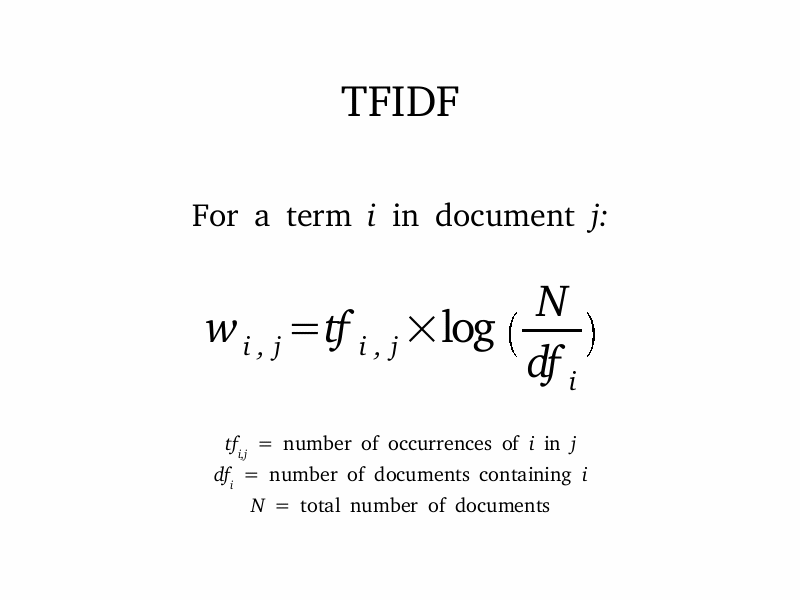

In [34]:
Image('pics/tfidf.png')

Подробнее про tf-idf можно прочитать здесь: https://ru.wikipedia.org/wiki/TF-IDF

In [35]:
pipeline = make_pipeline(CountVectorizer(min_df=3, ngram_range=(1, 2)),
                         TfidfTransformer(),
                         LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring='accuracy')
print(arr)
print(np.mean(arr))

[0.925      0.92083333 0.89121339 0.86610879 0.88702929]
0.898036959553696


In [36]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [37]:
print('Train accuracy', accuracy_score(pipeline.predict(train_data.data), train_data.target))
print('Test accuracy', accuracy_score(pipeline.predict(test_data.data), test_data.target))

Train accuracy 0.9807852965747702
Test accuracy 0.8944723618090452
